# GAN Monet Challenge

## Brief Description of The Problem and Data

This project is part of the Kaggle competition "GAN Getting Started", which involves generating high-quality images using Generative Adversarial Networks(GANs). The challenge focuses on understanding the process of using GANs for image generation tasks, specifically creating artistic images inspired by Monet's paintings.

GANs are a type of deep learning model consisting of two neural networks: a generator and a discriminator. The generator creates fake images, while the discriminator attempts to distinguish between real and fake images. Through iterative training, the generator improves its ability to create realistic images, while the discriminator sharpens its classification accuracy.

Here is the link for competition: https://www.kaggle.com/competitions/gan-getting-started/overview

The dataset includes:

300 Monet paintings (monet_jpg)
7,028 photos (photo_jpg)
Each image is 256x256 pixels in size, and the challenge requires generating a large set of fake images that emulate Monet’s style. The goal is to produce between 7,000 to 10,000 high-quality images using the GAN model.

In [49]:
# Libraries

import os
import PIL
from PIL import Image
import shutil
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import tensorflow as tf
import re
group_normalization = tf.keras.layers.GroupNormalization
from tensorflow.python.keras import layers, models, optimizers, Model
adam = tf.keras.optimizers.Adam
import time
from IPython import display
from IPython.display import clear_output

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

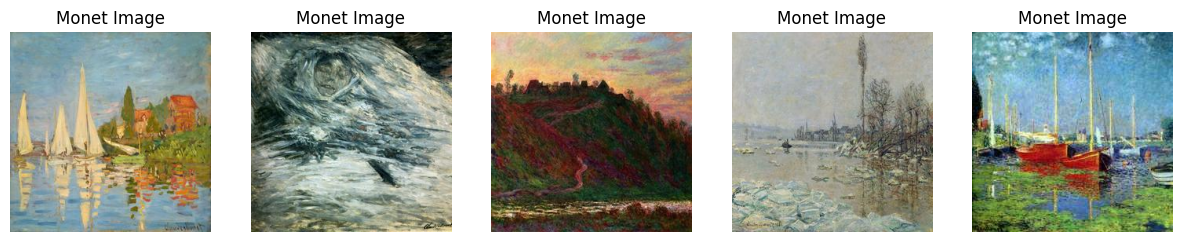

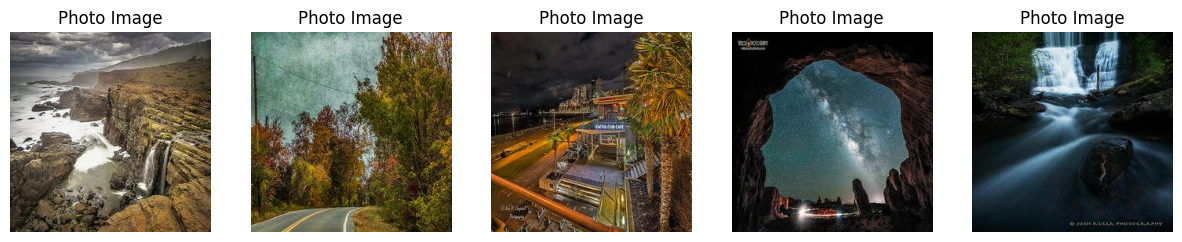

In [2]:
monet_path = Path('./data/monet_jpg')
photo_path = Path('./data/photo_jpg')

def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f'{title}')
        plt.axis('off')
    plt.show()

sample_monet_images = list(monet_path.glob('*.jpg'))[:5]
sample_photo_images = list(photo_path.glob('*.jpg'))[:5]

display_images(sample_monet_images, "Monet Image")
display_images(sample_photo_images, "Photo Image")

Coming from non-art background, in my eyes Monet photos look like art and stylish while other photos have more vivid colors.
Let's analyza the color distribution of images.

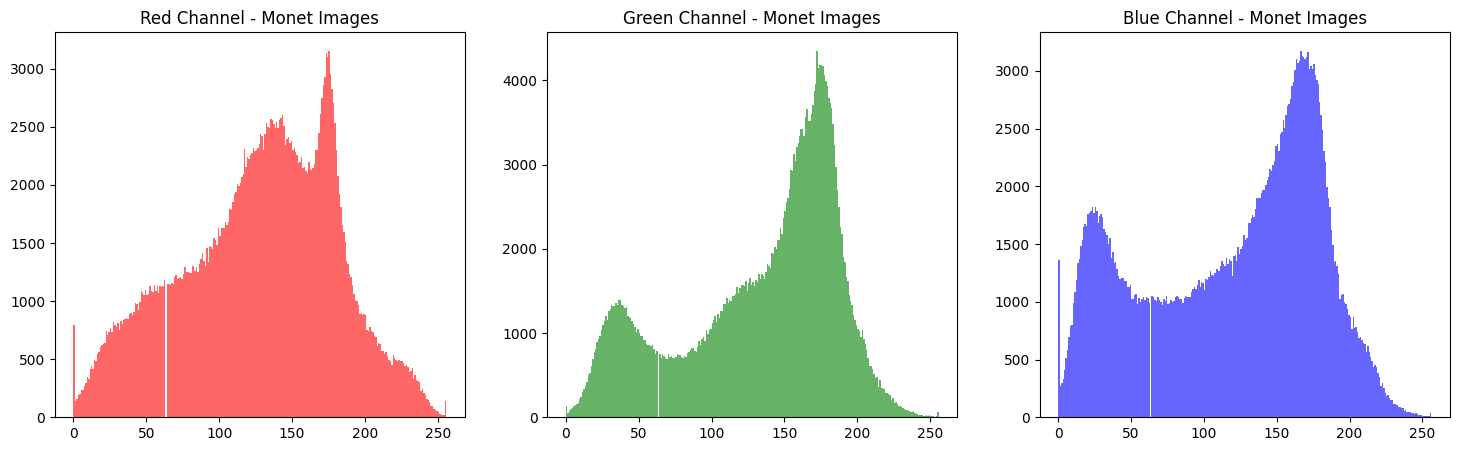

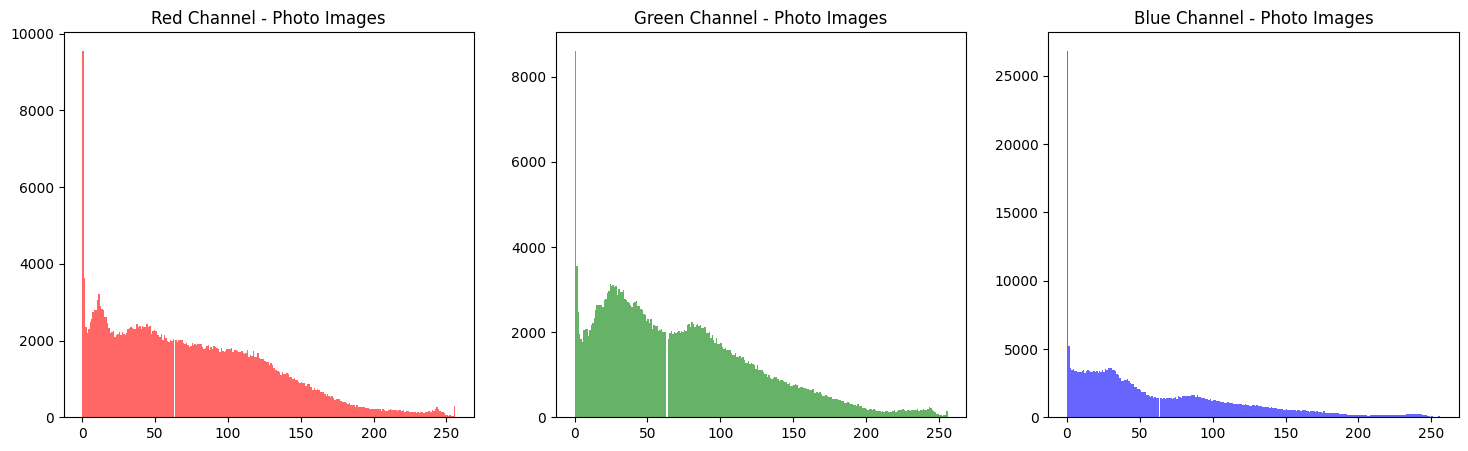

In [ ]:
def calculate_rgb_distribution(images):
    red_values = []
    green_values = []
    blue_values = []

    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
            red_values.extend(((img[:, :, 0] + 1) * 127.5).flatten())
            green_values.extend(((img[:, :, 1] + 1) * 127.5).flatten())
            blue_values.extend(((img[:, :, 2] + 1) * 127.5).flatten())
        else:
            raise ValueError("Image is not in the correct RGB format")
    return red_values, green_values, blue_values

def plot_rgb_distribution(red, green, blue, title):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.hist(red, bins=256, color='red', alpha=0.6, range=(0, 256))
    plt.title(f'Red Channel - {title}')

    plt.subplot(1, 3, 2)
    plt.hist(green, bins=256, color='green', alpha=0.6, range=(0, 256))
    plt.title(f'Green Channel - {title}')

    plt.subplot(1, 3, 3)
    plt.hist(blue, bins=256, color='blue', alpha=0.6, range=(0, 256))
    plt.title(f'Blue Channel - {title}')

    plt.show()

# Load images from file paths
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(str(path))  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = img.astype(np.float32) / 127.5 - 1  # Normalize to [-1, 1]
        images.append(img)
    return images

monet_image_paths = list(Path("./data/monet_jpg").glob("*.jpg"))[:5]
photo_image_paths = list(Path("./data/photo_jpg").glob("*.jpg"))[:5]

monet_images_analysis = load_images(monet_image_paths)
photo_images_analysis = load_images(photo_image_paths)

# Calculate RGB distributions for both datasets
red_A, green_A, blue_A = calculate_rgb_distribution(monet_images_analysis)
red_B, green_B, blue_B = calculate_rgb_distribution(photo_images_analysis)

# Plot RGB distributions
plot_rgb_distribution(red_A, green_A, blue_A, 'Monet Images')
plot_rgb_distribution(red_B, green_B, blue_B, 'Photo Images')


As histogram shows, Monet images have more intense use of 3 colors and have more dramatic peaks, while photo images are generally well balanced. 
Now I will proprocess the images in order to be used to build the model in next step.

### Proprocess Images

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Normalise
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image

# Read TFRecord
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Augment
def data_augment(image):
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

MONET_FILENAMES = tf.io.gfile.glob(str('./data/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str('./data/photo_tfrec/*.tfrec'))

monet_ds = load_dataset(MONET_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(PHOTO_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


Displaying Monet images:


2024-11-30 23:29:10.374358: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-11-30 23:29:10.406722: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


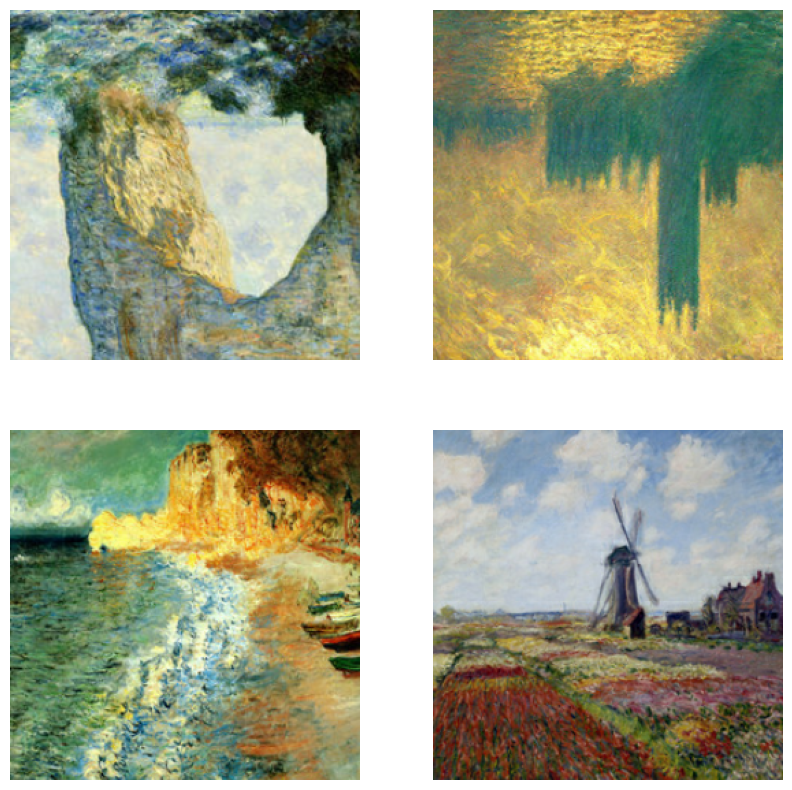

Displaying Photo images:


2024-11-30 23:29:10.776783: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


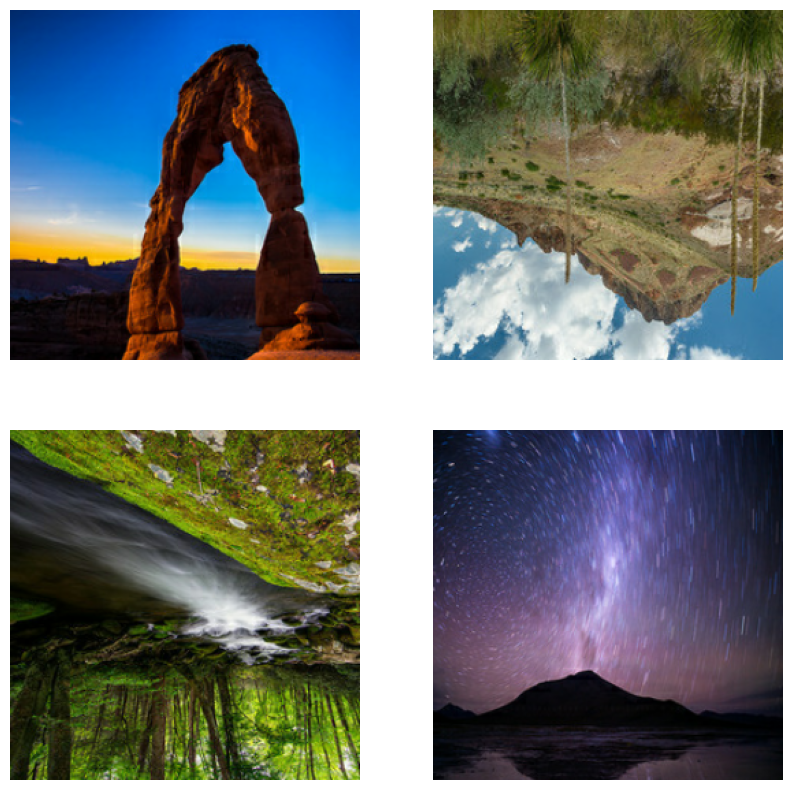

In [ ]:
def show_batch(dataset):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):
        for i in range(BATCH_SIZE):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow((images[i].numpy() + 1) / 2)
            plt.axis("off")
    plt.show()

print("Displaying Monet images:")
show_batch(monet_ds)

print("Displaying Photo images:")
show_batch(photo_ds)

## Model Architecture

CycleGAN(Cycle-Consistent Generative Adversarial Network) is a type of GAN designed for image-to-image translation tasks where paired training data(e.g., matching Monet and photo images) are not available. It can learn to translate images from one domain(e.g., photos) to another(e.g., Monet paintings) without requiring paired examples.

Why is CycleGAN Suitable for This Task?

1. Unpaired Dataset Compatibility

- In many real-world scenarios, we do not have one-to-one mappings between source and target domain images (e.g., a photo and its exact Monet painting equivalent).
- CycleGAN can effectively train using unpaired datasets of photos and Monet paintings by learning the style transfer in both directions (photo→Monet and Monet→photo).

2. Style Transfer Capabilities

- The architecture is specifically designed for style transfer tasks like generating Monet-style paintings from regular photos. The generators focus on preserving content while changing the style.

3. Cycle-Consistency Loss

- Ensures that when an image is transformed (photo→Monet→photo), the original content remains consistent. This helps maintain realism and prevents mode collapse, where the generator might only produce highly unrealistic or repetitive outputs.

4. Dual Discriminators for Realism

- The discriminators in CycleGAN ensure that the generated Monet-style images look indistinguishable from real Monet paintings, improving quality.

5. No Pairing Constraint

- Unlike standard GANs for image-to-image translation (e.g., Pix2Pix), CycleGAN eliminates the need for paired datasets, making it highly practical for art-style transfer tasks.

6. High-Quality, Diverse Outputs

- CycleGAN can produce a variety of Monet-style images without sacrificing content fidelity, which is ideal for generating the required 7,000–10,000 high-quality images for your task.

In [ ]:
def downsample(filters, size, apply_norm=True):
    """
    Creates a downsampling block for the generator or discriminator in CycleGAN.
    This block reduces the spatial dimensions of the input using a Conv2D layer 
    and applies optional normalization and activation.

    Args:
        filters (int): Number of filters in the Conv2D layer, determining the depth of the output.
        size (int): Kernel size for the Conv2D layer.
        apply_norm (bool): Whether to apply normalization after the Conv2D operation.

    Returns:
        tf.keras.Sequential: A sequential model containing the downsampling layers.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(group_normalization(groups=-1))
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    """
    Creates an upsampling block for the generator in CycleGAN.
    This block increases the spatial dimensions of the input using a Conv2DTranspose layer 
    and applies normalization, optional dropout, and activation.

    Args:
        filters (int): Number of filters in the Conv2DTranspose layer, determining the depth of the output.
        size (int): Kernel size for the Conv2DTranspose layer.
        apply_dropout (bool): Whether to apply dropout after the normalization layer.

    Returns:
        tf.keras.Sequential: A sequential model containing the upsampling layers.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(group_normalization(groups=-1))
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
def make_generator():
    """
    Builds the generator model for a CycleGAN. 
    The generator transforms images from one domain to another (e.g., photos to Monet-style paintings).
    It consists of an encoder-decoder architecture with skip connections (U-Net structure).

    Returns:
        tf.keras.Model: The generator model.
    """
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    return models.Model(inputs=inputs, outputs=x)

In [ ]:
def make_discriminator():
    """
    Builds the discriminator model for a CycleGAN.
    The discriminator is a PatchGAN, which classifies patches of the input image as real or fake.
    This approach focuses on local features, making it suitable for style transfer tasks.

    Returns:
        tf.keras.Model: The discriminator model.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = inputs
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = group_normalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return models.Model(inputs=inputs, outputs=x)

In [36]:
monet_generator = make_generator()
photo_generator = make_generator()
monet_discriminator = make_discriminator()
photo_discriminator = make_discriminator()

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'sequential_1/conv2d/kernel:0' shape=(4, 4, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'sequential_2/conv2d_1/kernel:0' shape=(4, 4, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2), but
are not present in its tracked objects:
  <tf.Variable 'sequential_3/conv2d_2/kernel:0' shape=(4, 4, 128, 256) dt

In [37]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [38]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss * 0.5

In [39]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:
LAMBDA = 10

def compute_cycle_loss(real_img, cycled_img):
    loss = tf.reduce_mean(tf.abs(real_img - cycled_img))
    return LAMBDA * loss

In [41]:
def identity_loss(real_img, same_img):
    loss = tf.reduce_mean(tf.abs(real_img - same_img))
    return LAMBDA * 0.5 * loss

In [43]:
# Optimizers
monet_generator_optimizer = adam(2e-4, beta_1=0.5)
photo_generator_optimizer = adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = adam(2e-4, beta_1=0.5)

In [ ]:
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # real monet -> fake photo
        fake_photo = monet_generator(real_monet, training=True)
        # fake photo -> monet
        cycled_monet = photo_generator(fake_photo, training=True)
        # real photo -> fake monet
        fake_monet = photo_generator(real_photo, training=True)
        # fake monet -> photo
        cycled_photo = monet_generator(fake_monet, training=True)
        # use for identity loss
        same_monet = monet_generator(real_monet, training=True)
        same_photo = photo_generator(real_photo, training=True)
        
        # The discriminators evaluate both real and fake images in each domain
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)
        
        # Generator losses: How well the generators fool the discriminators
        monet_gen_loss = generator_loss(disc_fake_photo)
        photo_gen_loss = generator_loss(disc_fake_monet)
        # Cycle consistency loss: Ensures that cycled images are similar to originals
        total_cycle_loss = compute_cycle_loss(real_monet, cycled_monet) + compute_cycle_loss(real_photo, cycled_photo)
        # Identity loss: Encourages generators to preserve input when it's already in the target domain
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
        # Discriminator losses: How well the discriminators distinguish real from fake images
        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
    
    # Computes the gradients for each model with respect to its loss.
    monet_generator_gradients = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
    monet_discriminator_gradients = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
    
    # Updates the model parameters using the calculated gradients.
    monet_generator_optimizer.apply_gradients(zip(monet_generator_gradients, monet_generator.trainable_variables))
    photo_generator_optimizer.apply_gradients(zip(photo_generator_gradients, photo_generator.trainable_variables))
    monet_discriminator_optimizer.apply_gradients(zip(monet_discriminator_gradients, monet_discriminator.trainable_variables))
    photo_discriminator_optimizer.apply_gradients(zip(photo_discriminator_gradients, photo_discriminator.trainable_variables))

In [45]:
def train(monet_dataset, photo_dataset, epochs):
    n = 0
    for epoch in range(epochs):
        start = time.time()
        for monet_image, photo_image in tf.data.Dataset.zip((monet_dataset, photo_dataset)):
            train_step(monet_image, photo_image)
            if n % 10 == 0:
                print ('.', end='')
            n += 1
        clear_output(wait=True)
        
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec')

In [46]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Monet-style Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [47]:
# Train the model
train(monet_ds, photo_ds, epochs=30)

Time taken for epoch 30 is 133.68730425834656 sec


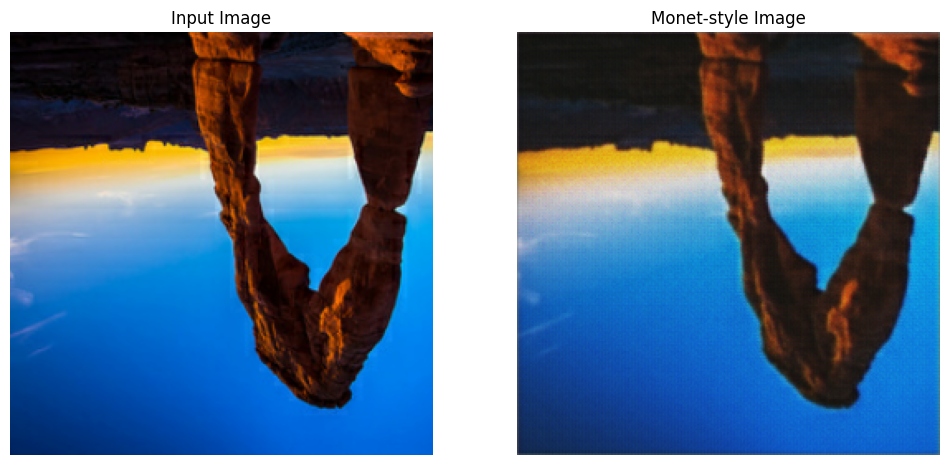

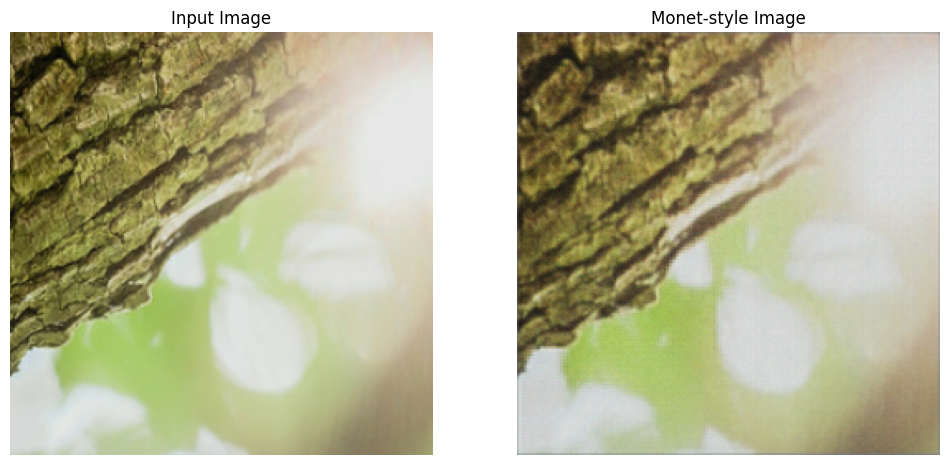

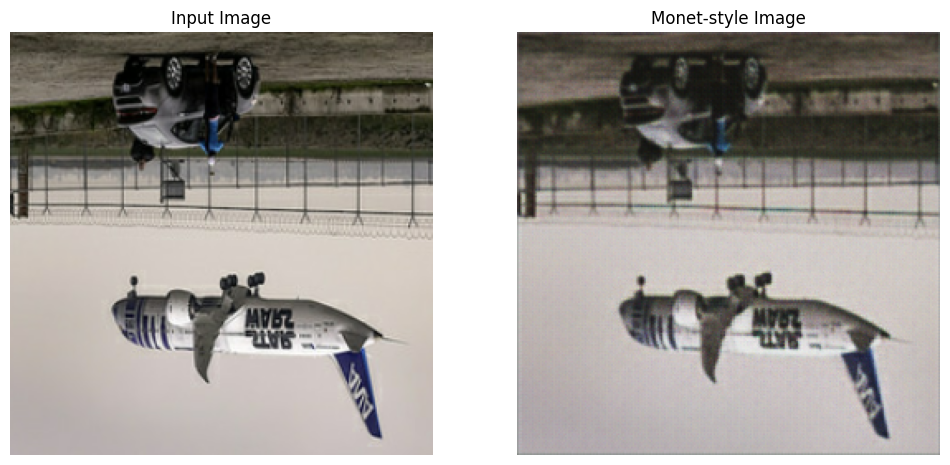

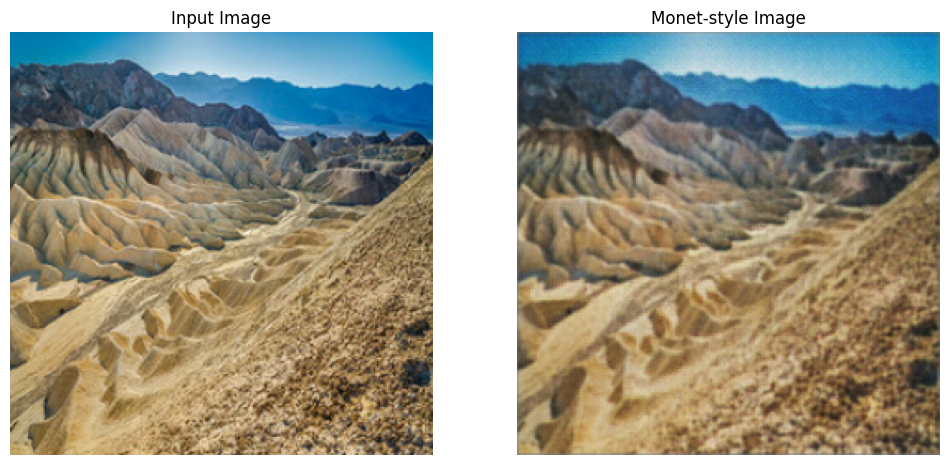

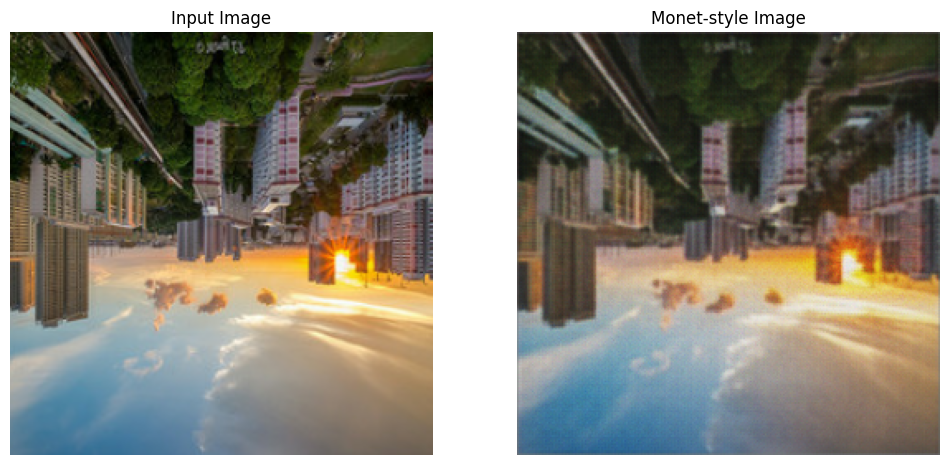

In [48]:
# Generate Monet-style image from 5 test photos
for photo in photo_ds.take(5):
    generate_images(monet_generator, photo)

## Results and Analysis

## Conclusion

## Submission

In [50]:
i = 1
for photo in photo_ds:
    prediction = monet_generator(photo, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./images/" + str(i) + ".jpg")
    i += 1
    
shutil.make_archive("images", 'zip', "./images")

'/Users/judoboyalex/Documents/boulders_mscs/coursera_ml/ml_deep_learning/monet_gan/images.zip'